# Bounded confidence model

In [1]:
import random
import numpy as np

from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.datacollection import DataCollector

import networkx as nx

In [2]:
# Agent

class OpinionAgent(Agent):
    def __init__(self, unique_id, model, pers, sup):
        super().__init__(unique_id, model)
        self.persuad = pers #np.random.randint(0, max_persuad)
        self.support = sup #np.random.randint(0, max_support)
        self.sigma_s = 0
        self.sigma_p = 0

    def interact(self):
        agent_list = self.model.schedule.agents
        agent_opinion = self.opinion
        sigma_p = 0
        sigma_s = 0
        n = 0
        for source_agent in agent_list:
            immediacy = self.model.distance_func(self, source_agent)
            if (source_agent.opinion == agent_opinion) and (immediacy != -1):  # -1 is for no connected
                sigma_s += source_agent.support * 2 / (immediacy ** 2)  # 2 for (1+sig_i*sig_j
            elif (source_agent.opinion != agent_opinion) and (immediacy != -1):
                sigma_p += source_agent.persuad * 2 / (immediacy ** 2)  # 2 for (1-sig_i*sig_j
            n += 1
        return sigma_s, sigma_p

    def step(self):
        self.sigma_s, self.sigma_p = self.interact()

    def advance(self):
#        print(self.unique_id, ': Advance:')
        rand_hi = random.uniform(-self.model.hi, self.model.hi)
        if (self.sigma_p - self.sigma_s + rand_hi) > 0:
            if self.opinion == 1:
                self.opinion = -1
                self.model.minus_opinion += 1
                self.model.plus_opinion -= 1
            elif self.opinion == -1:
                self.opinion = +1
                self.model.minus_opinion -= 1
                self.model.plus_opinion += 1
            else:
                print("Incorrect opinion")
                exit(1)


In [18]:
# Data collection

def get_opinion_ratio(model):
    '''
    Find the % of agents that are of opinion.
    '''
    
    N = model.Ag_num
    opinion_n = model.plus_opinion
    
    return opinion_n / N

In [19]:
# Model

class OpinionModel(Model):
    """A model with some number of agents."""
    def __init__(self, Ag, distribution, beta, rand_seed, hi_param):
        self.Ag_num = Ag
        self.pers_sup_dist = distribution
        self.hi = hi_param  # to generate uniform(-hi,hi)

        random.seed(rand_seed*9 +3)  # Generate different random seeds
        np.random.seed(rand_seed*9 + 3)  # Generate different random seeds
        self.running = True

        self.self_distance = 1
        self.pers_sup_max = 100
        self.distance = 1

        self.step_counter = 0
        self.step_list = []
        self.beta_final_num_list = []

        self.set_opinions_degrees(beta)

        self.schedule = SimultaneousActivation(self)
        
        self.datacollector = DataCollector(    # < Note that we have both an agent and model data collector
            model_reporters={"Plus_opinion": get_opinion_ratio}, agent_reporters={"Opinion": "opinion"}
        )
        
        # Create agents
        for x in range(Ag):
            pers, sup = self.set_pers_sup(x)
            a = OpinionAgent(x, self, pers, sup)
            a.opinion = self.opinion_array[x]
            self.schedule.add(a)

    def set_opinions_degrees(self, beta):
        self.opinion_array = np.ones(self.Ag_num, int)
        self.dmax = 0

        self.G = nx.barabasi_albert_graph(self.Ag_num, 2)  # barabasi_albert parameter = 2
        self.degree = self.G.degree()
        node_degree = [self.degree[i] for i in range(len(self.degree))]
        sort_index = np.argsort(node_degree)  # Ascending, needed for 'BA_most_deg'
        sort_index = [sort_index[-i] for i in range(1, len(sort_index) + 1)]  # Descending
        self.dmax = node_degree[sort_index[0]] # I debugged it, node-degree was forgotted
        for i in range(int(self.Ag_num * beta / 100)):
            self.opinion_array[i] = -1
        self.minus_opinion = int(self.Ag_num * beta / 100)
        self.plus_opinion = self.Ag_num - self.minus_opinion
        np.random.shuffle(self.opinion_array)

    def set_pers_sup(self, i):
        if self.pers_sup_dist == 'uniform':
            return random.uniform(0, self.pers_sup_max), random.uniform(0, self.pers_sup_max)
        elif self.pers_sup_dist == 'deg_ratio':
            return round(self.pers_sup_max * self.degree[i] / self.dmax), \
                   round(self.pers_sup_max * self.degree[i] / self.dmax)
        else:
            print("incorrect parameter for set_pers_sup")

    def distance_func(self, d_agent, s_agent):
        if d_agent.unique_id == s_agent.unique_id:
            return self.self_distance
        elif self.G.has_edge(s_agent.unique_id, d_agent.unique_id):
            return self.distance # distance between two connected nodes is supposed 1
        else:
            return -1 # means no connection

    def step(self):
        self.datacollector.collect(self)
        
        self.schedule.step()
        self.step_counter += 1
        self.step_list.append(self.step_counter)
        self.beta_final_num_list.append(self.minus_opinion)


In [24]:
# Test the model

ag_num = 1000  # Number of agents
hi = 1000
beta = 20
seed=15

model = OpinionModel(Ag=ag_num, distribution='uniform', beta=beta, rand_seed=seed, hi_param=hi)
for i in range(100):
    model.step()

<AxesSubplot:>

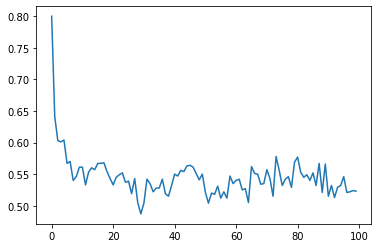

In [25]:
# Show results

model_data = model.datacollector.get_model_vars_dataframe()
model_data.Plus_opinion.plot()

In [26]:
opinions = model.datacollector.get_agent_vars_dataframe()
opinions.head()

Opinion
Step AgentID         
0    0             -1
     1             -1
     2              1
     3              1
     4             -1